In [1]:
from IPython.display import HTML 

In [2]:
import numpy as np
import pylab as py
def plot_gauss(mu,sigma, lim):
    ''' Funkcja rysująca kontury funkcji gęstości prawdopodobieństwa 
       dwuwymiarowego rozkładu Gaussa'''
 
    x = np.arange(lim[0], lim[1], 0.1)
    y = np.arange(lim[2], lim[3], 0.1)
    X,Y = np.meshgrid(x, y)
    X.shape = 1,len(x)*len(y)
    Y.shape = 1,len(x)*len(y)
    P = np.vstack((X,Y))
    invS = np.linalg.inv(sigma)
    R = P.T-mu
    z = np.zeros(len(R))
    for i in range(len(R)):
        z[i] = np.exp(-0.5*np.dot( R[i,:].T,np.dot(invS,R[i,:])))
 
    z.shape = len(x),len(y)
    py.contourf(x,y,z,alpha = 0.5)
    py.plot(mu[0],mu[1],'o')

# Powtórka
* Możliwe wyniki zastosowania klasyfikatora binarnego

<img src="https://drive.google.com/uc?id=1ojQ4IABTw7CspkVhqIKD6t3Pz7gjK1Kv" width = 800px>

* Konstrukcja krzywej ROC

<img src="https://drive.google.com/uc?id=1pXcIw5fdG2BN3gOYcuB0Gm1WpX8nqBrO" width=800px>

* kross-walidacja

* generalizacja

# Algorytmy generatywne

# Wstęp

Dotychczas mówiliśmy tylko o algorytmach uczących bazujących na modelowaniu rozkładów warunkowych zmiennych zależnych $y$ przy zadanym $x$ i sparametryzowanych przez $\theta $: 

$\qquad$$p(y|x;\theta )$, 

np.: regresja liniowa, logistyczna czy softmax.

Na podstawie przykładów z ciągu uczącego estymowana jest pewna granica między dwoma obszarami przestrzeni wejść. Decyzja co do klasy, którą reprezentuje nowy przypadek zależy tylko od tego, po której stronie granicy znajduje się ten przypadek.

Algorytmy, które estymują wprost rozkłady $(y|x)$ czy też mapowania z $X \rightarrow \lbrace 0,1\rbrace $ nazywamy **algorytmami dyskryminacyjnymi**.

Poniżej przykład 1D i 2D:

/Users/admin/anaconda3/lib/python3.7/site-packages/sklearn/utils/fixes.py:357: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if _joblib.__version__ >= LooseVersion('0.12'):


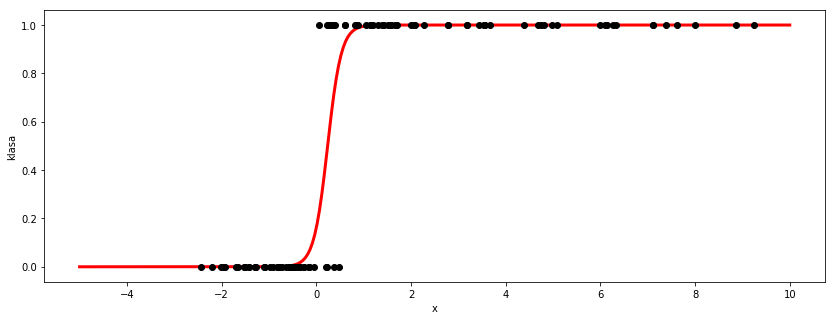

In [4]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model

# tworzymy jednowymiarowy zbiór uczący

xmin, xmax = -5, 5
n_samples = 100 
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0).astype(np.float) # przypisujemy klasę
X[X > 0] *= 4 
X += .3 * np.random.normal(size=n_samples) # torchę mieszamy punkty aby podział na klasy nie byl tak oczywisty
X = X[:, np.newaxis]

# tworzymy i uczymy klasyfikator
clf = linear_model.LogisticRegression(C=1e5, solver='lbfgs')
clf.fit(X, y)

# rysujemy wyniki
plt.figure(1, figsize=(14, 5))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)


def hipoteza(x):
    return 1 / (1 + np.exp(-x))
h = hipoteza(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, h, color='red', linewidth=3)
plt.xlabel('x')
plt.ylabel('klasa')

plt.show()

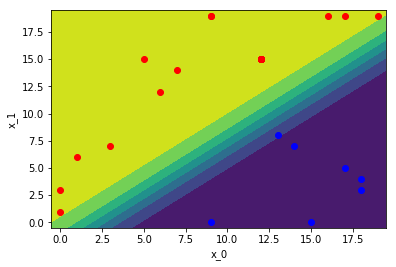

In [7]:
# ilustracja:
np.random.seed(0)
X = np.random.randint(20,size=(20,2))
theta = np.array([[-0.2],[0.3]])
Y = np.round( 1/(1+np.exp(np.dot(-X, theta))))
ind0 = np.where(Y==0)
ind1 = np.where(Y==1)
py.plot(X[ind0,0],X[ind0,1],'bo') 
py.plot(X[ind1,0],X[ind1,1],'ro')
py.xlabel("x_0")
py.ylabel("x_1")
# szykuję siątkę 
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

logreg = linear_model.LogisticRegression(solver='lbfgs') # inicjalizuję model
logreg.fit(X, Y.ravel()) # fituję model
Z = logreg.predict_proba(np.c_[xx.ravel(), yy.ravel()]) # robię predykcję dla każdego punktu siatki

#Z = Z.reshape(xx.shape)
py.contourf(xx,yy,Z[:,1].reshape(xx.shape)) # rysuję kontur rozdzielający klasy
py.xlim(xx.min(), xx.max())
py.ylim(yy.min(), yy.max())
py.show()

W tych dwóch powyższych przykładach przyjrzyjmy się jak powstaje hiperpowierzchnia rozdzielająca klasy.
* Jak ma się ona do hipotezy?

## Generatywne algorytmy uczące

Algorytmy generatywne modelują:
* rozkłady cech w klasach: $p(x|y)$ oraz
* prawdopodobieństwa występowania klas: $p(y)$.

Na podstawie ciągu uczącego stworzymy osobne modele tego, jakim rozkładom podlegają cechy w poszczególnych klasach. 

Po otrzymaniu nowego przypadku patrzymy, do której klasy jest on najbardziej podobny.

### Ilustracja rozkładu cech w poszczególnych klasach

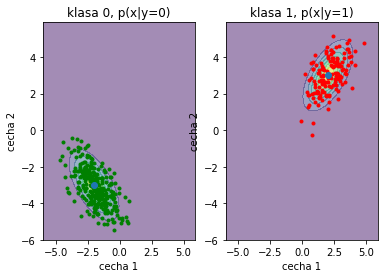

P(y=0) = N1/(N1+N2): 0.67
P(y=1) = N2/(N1+N2): 0.33


In [8]:

#parametry rozkładu
mu1 = [-2,-3] # wektor średnich:
Sigma1 = np.array([[1, -0.6], [-0.6, 1]]) # macierz kowariancji:
N1 = 300

mu2 = [2,3] # wektor średnich:
Sigma2 = np.array([[1, 0.6], [0.6, 1]]) # macierz kowariancji:
N2 = 150
# generujemy dane: 
z1 = np.random.multivariate_normal(mu1, Sigma1, N1) #
z2 = np.random.multivariate_normal(mu2, Sigma2, N2) #
py.subplot(1,2,1)
py.plot(z1[:,0],z1[:,1],'g.')
#py.axis('equal')
py.xlabel("cecha 1")
py.ylabel("cecha 2")
plot_gauss(mu1,Sigma1, [-6,6,-6,6])
py.title("klasa 0, p(x|y=0)")

py.subplot(1,2,2)
py.plot(z2[:,0],z2[:,1],'r.')
#py.axis('equal')
py.xlabel("cecha 1")
py.ylabel("cecha 2")
plot_gauss(mu2,Sigma2, [-6,6,-6,6])
py.title("klasa 1, p(x|y=1)") 
py.show()

print("P(y=0) = N1/(N1+N2): {0:.2f}".format( N1/(N1+N2)))
print('P(y=1) = N2/(N1+N2): {0:.2f}'.format( N2/(N1+N2)))

### Rozważmy przykład.
Chcemy odróżniać psy ($y=0$) od kotów ($y=1$) na podstawie zdjęć. 
* Umiemy określać cechy $x$ tych zwierząt. 
* Budujemy rozkłady tych cech dla psów: $p(x|y=0)$ i dla kotów $p(x|y=1)$. 
* Modelujemy także prawdopodobieństwo tego, że losowo wybrane zdjęcie przedstawia psa lub kota (np. na podstawie liczebności zdjęć obu gatunków w naszej bazie danych): $p(y)$ (jest to tzw. *prawdopodobieństwo apriori*).
* Wtedy można na podstawie wzoru Bayesa obliczyć prawdopodobieństwo a posteriori:

$\qquad$ $p(y|x) = \frac{p(x|y)p(y)}{p(x)}$

## Klasyfikator Bayesa
* Wzór Bayesa:  $p(y|x) = \frac{p(x|y)p(y)}{p(x)}$
* $p(x)$ można wyrazić za pomocą prawdopodobieństwa $p(x|y)$ i $p(y)$ następująco: 

$\qquad$ $p(x) = p(x|y=0)p(y=0) + p(x|y=1)p(y=1)$.

* Warto jednak zauważyć, że w problemie klasyfikacji nie interesuje nas tak naprawdę $p(x)$. 
 > Dlaczego? 

* W klasyfikacji chcemy odpowiedzieć na pytanie, która z klas jest najbardziej prawdopodobna, czyli dla jakiego $y$ $p(y|x)$ jest maksymalne. 
 * Ponieważ $p(x)$ nie zależy od $y$ więc: 

$\qquad$ $ \arg \max _y p(y|x) = \arg \max _y \frac{p(x|y)p(y)}{p(x)} = \arg \max _y p(x|y) p(y)$

## Dwuwymiarowe rozkłady Gaussa
* Funkcja gęstości prawdopodobieństwa dla $n$-wymiarowego rozkładu o wektorze średnim $\mu \in \mathcal {R}^n$ i macierzy kowariancji $\Sigma $ dana jest przez:

$\qquad$ $ p(x;\mu ,\Sigma ) = \frac{1}{(2\pi )^{n/2} |\Sigma |^{1/2}} \exp \left( -\frac{1}{2}(x-\mu )^T \Sigma ^{-1}(x-\mu )\right)$

gdzie: $|\Sigma |$ oznacza wyznacznik macierzy $\Sigma $.
* Oczywiście $\mu $ równe jest wartości oczekiwanej zmiennych z tego rozkładu:

$\qquad$ $E[X] = \int _x x p(x;\mu ,\Sigma )dx = \mu $

Macierz kowariancji natomiast dana jest wzorem:

$\qquad$ $\Sigma = E[(X-E[X])^T(X-E[X])]$

/Users/admin/anaconda3/lib/python3.7/site-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


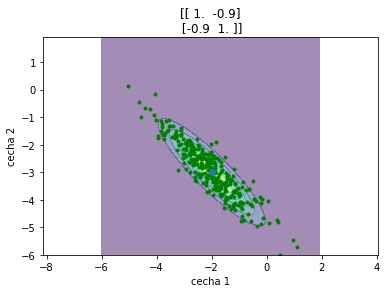

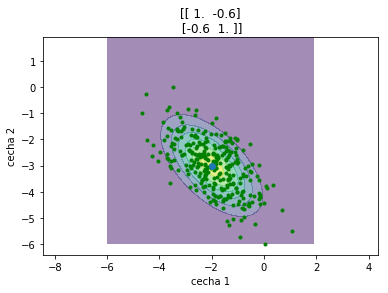

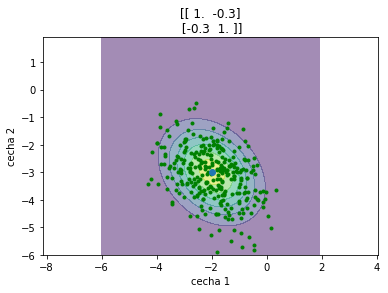

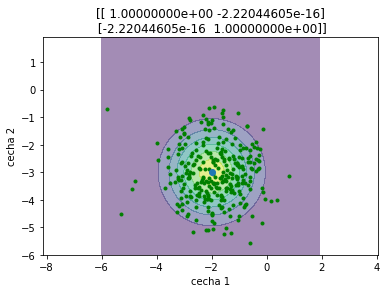

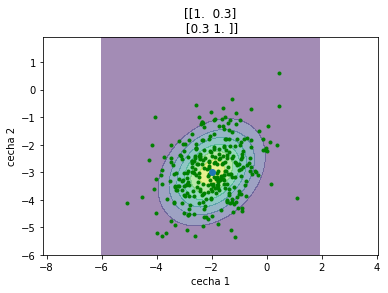

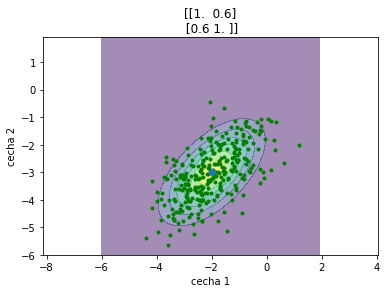

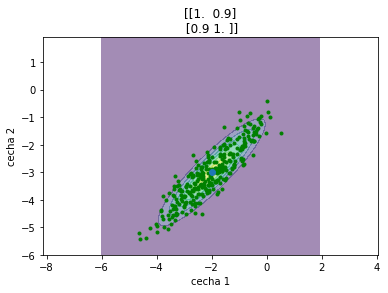

In [9]:
#parametry rozkładu
mu = [-2,-3] # wektor średnich:

for s in np.arange(-0.9,1,0.3):
    Sigma = np.array([[1, s],
                      [s, 1]]) # macierz kowariancji:
    # generujemy dane: 
    z1 = np.random.multivariate_normal(mu, Sigma, 300) #
    py.figure()
    py.plot(z1[:,0],z1[:,1],'g.')
    py.axis('equal')
    py.xlabel("cecha 1")
    py.ylabel("cecha 2")
    # w tle dorysujemy konturami funkcję gęstości prawdopodobieństwa
    plot_gauss(mu,Sigma, [-6,2,-6,2])
    py.title(Sigma)
    py.show()


## Gaussowska analiza dyskryminacyjna

Pierwszym algorytmem generatywnym, z którym się zapoznamy będzie gaussowska analiza dyskryminacyjna (GAD).
* W tej analizie zakładamy, że dane niezależne, przy ustalonej klasie, pochodzą z wielowymiarowego rozkładu normalnego: $p(x|y) \sim N(\mu , \Sigma )$.



### Parametry modelu GAD 
Dla pełnej specyfikacji modelu gaussowskiej analizy dyskryminacyjnej musimy założyć, że następujące zmienne mają wskazane rozkłady:

$\qquad$
$\begin{matrix}
y &\sim & \textrm {Bernoulli}(\phi ) \\
(x|y=0) &\sim & N(\mu _0,\Sigma_0 ) \\
(x|y=1) &\sim & N(\mu _1,\Sigma_1 )
\end{matrix}$


zapisując to przy pomocy odpowiednich funkcji gęstości prawdopodobieństwa mamy:

$\qquad$
$\begin{matrix}
p(y) &=& \phi ^y (1-\phi )^{1-y}  \\
p(x|y=0) &=& \frac{1}{(2\pi )^{n/2} |\Sigma_0 |^{1/2}} \exp \left( -\frac{1}{2}(x-\mu _0)^T \Sigma_0 ^{-1}(x-\mu _0)\right)\\
p(x|y=1) &=& \frac{1}{(2\pi )^{n/2} |\Sigma_1 |^{1/2}} \exp \left( -\frac{1}{2}(x-\mu _1)^T \Sigma_1 ^{-1}(x-\mu _1)\right)
\end{matrix}$

### Parametry, które trzeba wyuczyć

Nasz model jest sparametryzowany przez 

$\phi $, $\mu _0$, $\mu _1$, $\Sigma_0 $ i $\Sigma_1 $. 



## Uczenie GADa
* Do wyznaczenie parametrów możemy zastosować metodę największej wiarygodności. 
 > Co jest nam potrzebne aby zastosować tą technikę?

------
Definicja (Prawdopodobieństwo warunkowe)

Niech $A,B\in \Omega$, i $P(A) \gt 0$. 
Wtedy prawdopodobieństwem $B$ pod warunkiem $A$ nazywamy:
$P(B|A)=\frac{P(A\cap B)}{P(A)}$

-------
Czyli $P(A\cap B) = P(B|A)P(A)$

* zbiór uczący $\left\lbrace \left(x^{(j)},y^{(j)}\right) \right\rbrace _{j=1,\dots ,m}$ 
* funkcję log-wiarygodności:

$\qquad$
$\begin{matrix}
l(\phi ,\mu _0,\mu _1,\Sigma ) &=& \log \prod _{j=1}^m p \left( x^{(j)}, y^{(j)}; \phi ,\mu _0,\mu _1,\Sigma_0,\Sigma_1 \right)\\
&=& \log \prod _{j=1}^m p \left( x^{(j)}|y^{(j)}; \mu _0,\mu _1,\Sigma_0,\Sigma_1 \right)p(y^{(j)};\phi )\\
&=& \sum _{j=1}^m \log \left[p \left( x^{(j)}|y^{(j)}; \mu _0,\mu _1,\Sigma_0,\Sigma_1 \right)p(y^{(j)};\phi )\right]
\end{matrix}$

Jakie poczyniliśmy tu założenie?

Maksymalizując funkcję log wiarygodności względem parametrów otrzymujemy:

$\qquad$
$\begin{matrix}
\phi &=& \frac{\sum _{j=1}^m 1\lbrace y^{(j)}==1\rbrace }{m}\\
\mu _0 &=& \frac{\sum _{j=1}^m 1\lbrace y^{(j)}==0\rbrace  x^{(j)} }{\sum _{j=1}^{m} 1\lbrace y^{(j)}==0\rbrace }\\
\mu _{1} &=& \frac{\sum _{j=1}^{m}1\lbrace y^{(j)}==1\rbrace x^{(j)}}{\sum _{j=1}^{m} 1\lbrace y^{(j)}==1\rbrace }\\
\Sigma_0 &=& \frac{1}{\sum _{j=1}^{m} 1\lbrace y^{(j)}==0\rbrace }\sum _{j \in C_{y=0}}^{m}(x^{(j)} - \mu _{y^{(j)}})^{T}(x^{(j)} - \mu _{y^{(j)}})\\
\Sigma_1 &=& \frac{1}{\sum _{j=1}^{m} 1\lbrace y^{(j)}==1\rbrace }\sum _{jin C_{y=1}}^{m}(x^{(j)} - \mu _{y^{(j)}})^{T}(x^{(j)} - \mu _{y^{(j)}})
\end{matrix}$

## Klasyfikacja GAD
Kiedy już mamy dopasowane parametry modelu możemy robić przy jego pomocy klasyfikację (przewidywania) co od nowych przypadków. Przewidywaną klasą będzie, zgodnie z tym co mówiliśmy na początku wykładu:

$\qquad$$y_{przewidywane} = \arg \max _y p(y|x) = \arg \max _y \frac{p(x|y)p(y)}{p(x)}$

$\qquad$$\qquad$$\qquad$$ = \arg \max _y p(x|y) p(y)$

# Powierzchnie decyzyjne w GDA: QDA i LDA
Przyjrzyjmy się teraz bliżej powierzchniom decyzyjnym powstającym w klasyfikacji GAD. Powierzchnia ta danajest równaniem:

$p(x|y=0)p(y=0) = p(x|y=1)p(y=1)$

Podstawiając jawnie postacie funkcji gęstości prawdopodobieństwa dostajemy:

$\begin{matrix}
\frac{1}{(2\pi )^{n/2} |\Sigma_0 |^{1/2}} \exp \left( -\frac{1}{2}(x-\mu _0)^T \Sigma_0 ^{-1}(x-\mu _0)\right)\cdot p(y=0)\\
 = \frac{1}{(2\pi )^{n/2} |\Sigma_1 |^{1/2}} \exp \left( -\frac{1}{2}(x-\mu _1)^T \Sigma_1 ^{-1}(x-\mu _1)\right)\cdot p(y=1)
 \end{matrix}$

Logarytmując stronami dostajemy:

$\begin{matrix}
-\frac{n}{2} \log 2\pi - \frac{1}{2}\log|\Sigma_0|  -\frac{1}{2}(x-\mu _0)^T \Sigma_0 ^{-1}(x-\mu_0) + \log p(y=0)\\
 = -\frac{n}{2} \log 2\pi - \frac{1}{2}\log|\Sigma_1|  -\frac{1}{2}(x-\mu_1)^T \Sigma_1 ^{-1}(x-\mu_1) + \log p(y=1)
 \end{matrix}$
 
redukujemy, i zauważamy elementy stałe: 
 
 $\begin{matrix}
 \underline{- \frac{1}{2}\log|\Sigma_0|}
 -\frac{1}{2}(x-\mu _0)^T \Sigma_0 ^{-1}(x-\mu_0) +
 \underline{\log p(y=0)}\\
 =  
 \underline{- \frac{1}{2}\log|\Sigma_1|}  
 -\frac{1}{2}(x-\mu_1)^T \Sigma_1 ^{-1}(x-\mu_1) +
 \underline{\log p(y=1)}
 \end{matrix}$
 
 Czyli jest to jakiś **wielomian $x$ stopnia co najwyżej 2**.
 
 Stąd nazwa QDA - quadratic discriminant analysis. 

QDA
<img src="https://drive.google.com/uc?id=1HaVUlkDSeXPaZUDKo6tAKMLZkrKawCn_" width = 800px>

Wszystko znacznie się upraszcza jeśli założymy, że $\Sigma_0 = \Sigma_1 = \Sigma$

$\begin{matrix}
 \underline{- \frac{1}{2}\log|\Sigma|}
 -\frac{1}{2}(x-\mu _0)^T \Sigma ^{-1}(x-\mu_0) +
 \underbrace{\log p(y=0)}\\
 =  
 \underline{- \frac{1}{2}\log|\Sigma|}  
 -\frac{1}{2}(x-\mu_1)^T \Sigma^{-1}(x-\mu_1) +
 \underbrace{\log p(y=1)}
 \end{matrix}$

$\begin{matrix}
 -\frac{1}{2}(x-\mu _0)^T \Sigma ^{-1}(x-\mu_0)\quad+
 \quad \frac{1}{2}(x-\mu_1)^T \Sigma^{-1}(x-\mu_1) 
 \\
 =  
{\log p(y=1)} - {\log p(y=0)}
 \end{matrix}$

$
 -(x-\mu _0)^T \Sigma ^{-1}(x-\mu_0) +(x-\mu_1)^T \Sigma^{-1}(x-\mu_1) =
 2 \log \frac{p(y=1)}{p(y=0)}
 $

$x^T\Sigma^{-1}x - x^T\Sigma^{-1}\mu_1 -\mu_1^T\Sigma^{-1}x +\mu_1^T\Sigma^{-1}\mu_1
-x^T\Sigma^{-1}x + x^T\Sigma^{-1}\mu_0 +\mu_0^T\Sigma^{-1}x -\mu_0^T\Sigma^{-1}\mu_0\\
 =
 2 \log \frac{p(y=1)}{p(y=0)}
 $

$
(\mu_0-\mu_1)^T\Sigma^{-1}x 
+ x^T\Sigma^{-1}(\mu_0-\mu_1)
 =
 2 \log \frac{p(y=1)}{p(y=0)}-\mu_1^T\Sigma^{-1}\mu_1
 +\mu_0^T\Sigma^{-1}\mu_0
 $

$
2x^T\Sigma^{-1}(\mu_0-\mu_1)
 =
 2 \log \frac{p(y=1)}{p(y=0)}-\mu_1^T\Sigma^{-1}\mu_1
 +\mu_0^T\Sigma^{-1}\mu_0
 $

$
x^T
\underbrace{\Sigma^{-1}(\mu_0-\mu_1)}_{wektor}
 =
  \underbrace{\log \frac{p(y=1)}{p(y=0)} + \frac{1}{2}\left(\mu_0^T\Sigma^{-1}\mu_0 - \mu_1^T\Sigma^{-1}\mu_1
 \right)}_{const = T}
 $

<img src="https://drive.google.com/uc?id=1HaYte6-b2-fw7DPaNKKkCSWHSqNT0ayQ" width=800px>

Zauważmy, że:
- liniowość jest wynikiem założenia równych wariancji
- czynnik $\Sigma^{-1}$ w wektorze na który rzutujemy koryguje jego kierunek biorąc pod uwagę 'rozciagłość' macierzy kowariancji
- położenie progu decyzyjnego $T$ zależy od stosunku częstosći występowania klas

Gdybyśmy estymowali $\Sigma$ osobno dla kazdej z klas z ciągu uczącego, to nawet jeśli w rzeczywistości kalsy mają równe macierze kowariancji to ze skończonego zbioru raczej nie dostaniemy tego.

W praktyce estymujemy weariancję łączną (*pooled variance*):

$\hat \Sigma = \frac{1}{n-2} \sum_{k=0}^1 \sum_{j\in C_k} (x^{(j)} - \mu_k)(x^{(j)} - \mu_k)^T$ 

<img src="https://drive.google.com/uc?id=1HbBXAYorSVWTTQdDBtqnXcaYPh6JhNHq" width=800px>

Jeszcze jedna uwaga praktyczna:
    
- We wzorze na rzutowanie występuje odwrotność macierzy kowariancji. Jest to potencjalne źródło niestabilności numerycznych jeśli wystąpią małe wartości własne
- Aby temu zaradzić stosuje się różne regularyzacje, np.:
  - $\Sigma^{-1} \rightarrow \left(\Sigma +\lambda I \right)^{-1}$ 
  albo 
  - $\Sigma^{-1} \rightarrow \left((1-\lambda)\Sigma +\lambda I \right)^{-1} \qquad \lambda \in (0,1)$ 
  - $\lambda$ jest dobierana w procedurze np. walidacji krzyżowej

## Porównianie funkcji log-wiarygodniści dla GAD i regresji logistycznej

Wielkości występujące w tym wzorze dane są przez równania.

$\qquad$ $l(\phi ,\mu _0,\mu _1,\Sigma_0,\Sigma_1 ) = \log \prod _{j=1}^m p \left( x^{(j)}, y^{(j)}; \quad \phi ,\mu _0,\mu _1,\Sigma_0,\Sigma_1 \right)$ 

Porównajmy tą funkcję z analogiczną funkcją dla regresji logistycznej:


$\qquad$ $l({\theta }) = \log \prod _{j=1}^{m}p(y^{(j)}|x^{(j)};\quad \theta )$

> Zwróćmy uwagę, że w tym wzorze, jak i we wszystkich wzorach na funkcję log-wiarygodności w algorytmach dyskryminacyjnych, występuje prawdopodobieństwo warunkowe klasy $y$ mając dany $x$: $p(y|x)$, zaś w przypadku algorytmów generatywnych mamy prawdopodobieństwa wspólne $p(x,y)$.



## Gaussowska analiza dyskryminacyjna a regresja logistyczna
### Przykład w 1-D:
* dwa gaussy:
  * pierwszy $p(x|y=0)$ odpowiada klasie y = 0 
  * a drugi $p(x|y=1)$ klasie $y = 1$. 
  

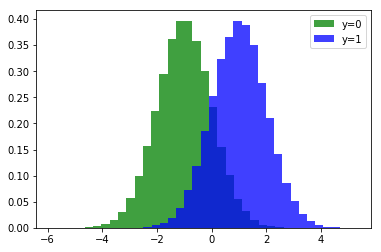

In [26]:
N = 100000
np.random.seed(0)
x_y0 = np.random.randn(N)-1  
x_y1 = np.random.randn(N)+1
py.subplot(1,1,1)
py.hist(x_y0,30, density=True, facecolor='green', alpha=0.75)
py.hist(x_y1,30, density = True, facecolor='blue', alpha=0.75)
py.legend(("y=0","y=1"))
py.show()

Zastanówmy się jakie jest prawdopodobieństwo 

$\qquad$ $p(y=1|x) = \frac{p(x|y=1)p(y=1)}{p(x)}$ 

dla różnych wartości $x$ ? 

Połączmy nasze dwa rozkłady: 

In [28]:
x = np.hstack((x_y0,x_y1))
y = np.hstack( (np.zeros(N),np.ones(N)))
print(x)
print(y)

[ 0.76405235 -0.59984279 -0.02126202 ...  1.66781483 -0.02119452
  0.65462684]
[0. 0. 0. ... 1. 1. 1.]


Obliczamy $p(y = 1)$:

In [29]:
p_y1 = np.sum(y==1)/len(y)

Obliczamy prawdopodobieństwa $p(x|y=1)$ i $p(x)$

In [30]:
bin = 0.3
bins = np.arange(np.min(x),np.max(x),bin)
p_x_y1 = np.zeros(len(bins))
p_x = np.zeros(len(bins))
for i,xx in enumerate(bins):
    # prawdopodobieństwo, że x_y1 wpada do binu i-tego
    p_x_y1[i] = np.sum( np.logical_and( xx< x_y1 , x_y1 <xx+bin ))/len(x_y1)
     # prawdopodobieństwo, że x wpada do binu i-tego
    p_x[i] = (np.sum( np.logical_and( xx< x , x <xx+bin )))/(len(x))
    

Stosujemy wzór Bayesa:

In [31]:
p_y1_x = (p_x_y1 * p_y1)/p_x

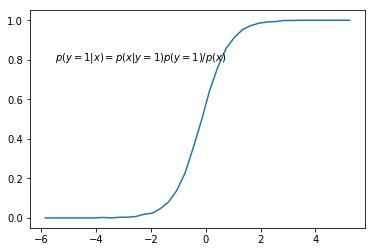

In [33]:
py.subplot(1,1,1)
py.plot( bins,p_y1_x)
py.text(-5.5,.8,"$p(y=1|x) = p(x|y=1)p(y=1)/p(x)$ ")
py.show()

## Otrzymujemy sigmiodę!

## Gaussowska analiza dyskryminacyjna a regresja logistyczna
Istnieje ciekawa relacja między GAD a regresją logistyczną. Obie metody dają w efekcie pewną hiperpowierzchnię separującą obszary przestrzeni wejść na przynależną do klasy 0 bądź 1.
Prawdopodobieństwo warunkowe klasy w modelu GAD można też wyrazić w postaci:

$\qquad$ $p(y|x;\phi ,\Sigma ,\mu _{0},\mu _{1}) = \frac{1}{1+\exp(-\theta ^{T}x)}$

przy czym $\theta $ jest pewną funkcją parametrów modelu $\phi , \Sigma , \mu _{0},\mu _{1}$. Co do formy uzyskujemy analogiczny wynik, chociaż w ogólności wynikające z tego proste (hiperpowierzchnie) decyzyjne będą różne dla GAD i 
regresji logistycznej, pomimo użycia tego samego zbioru uczącego. 

### Który model jest lepszy ?
Możemy narysować taki schemat:

$\qquad$ $\begin{matrix}
(x|y) &\sim & Gaussowski\\
&\Downarrow & \textrm { ale } \Uparrow \textrm { nie zachodzi} \\
p(y|x) &\sim &f. logistyczna
\end{matrix}$

* Dla wielu rozkładów $(x|y)$ należących do rodziny wykładniczej otrzymujemy $p(y|x)$ w postaci logistycznej. 
* Wynika stąd, że założenie gaussowskiej postaci $(x|y)$ jest mocniejszym założeniem niż logistyczna postać $p(y|x)$.

### Zatem odpowiedź, które podejście jest lepsze zależy od danych. 
* Model GAD oparty jest o założenie, że rozkłady warunkowe danych $p(x|y)$ są wielowymiarowymi rozkładami normalnymi.
* Jeśli to założenie jest prawdziwe, to model GAD wykorzystuje więcej informacji, bo ”zna” cały rozkład danych - dane ze zbioru uczącego służą jedynie do estymacji parametrów tego rozkładu. 
* Z drugiej strony regresja logistyczna robi znacznie słabsze założenia co do danych w związku z czym jest bardziej odporna na odstępstwa rozkładów danych wejściowych od założeń.

## Naiwny Klasyfikator Bayesa

* Klasyfikator GAD działał na danych ciągłych. 
* Jak można zbudować kalsyfikator generatywny dla danych dyskretnych?
* Jako przykład omówimy naiwny klasyfikator Bayesa. Klasyfikator ten zaprezentujemy na przykładzie filtra antyspamowego.

### Reprezentacja listu
* Załóżmy, że jako zbiór uczący mamy kolekcję listów oznaczonych jako spam albo nie-spam
> Jak można reprezentować listy?

* Jednym z popularnych podejść jest metoda słownikowa. Przeglądamy duży zestaw listów, sporządzamy listę słów, które wystąpiły w tych listach, porządkujemy alfabetycznie i otrzymujemy _słownik_.

* Mając taki słownik możemy każdy list zakodować jako wektor kolumnowy złożony z zer i jedynek. Jedynka na i-tej pozycji oznacza, że w liście wystąpiło i-te słowo z naszego słownika. 

### Przykładowy list mógłby wyglądać tak:

$\qquad$ 
$
x = \left[
\begin{array}{c}
0 \\
0 \\
\vdots \\
1 \\
\vdots \\
1 \\
\vdots \\
1 \\
\vdots \end{array}
\right]
\begin{array}{l}
aby \\
ale \\
\vdots \\
pozdrawiam \\
\vdots \\
witaj \\
\vdots \\
widzialem \\
\vdots \end{array}
$

* Każdy $x_{i}$ ($i$-ta współrzędna wektora $x$) może przyjąć wartość 1 albo 0 w zależności od tego czy $i$-te słowo ze słownika wystąpiło w liście czy też nie. 
* Zauważmy, że kodowanie to pomija informację o częstości danego słowa w liście.

### Rozważania o rozmiarach
* Widać, że rozmiar $x$ może być bardzo duży. Jest on równy rozmiarowi słownika.
* Mając wybrany sposób reprezentacji listów możemy przystąpić do budowania modelu dyskryminacyjnego. 
* Potrzebjemy wyznaczyć $p(x|y)$. 
* Jeśli rozmiar naszego słownika to 5000 słów to $x$ są 5000-wymiarowymi wektorami z wartościami 0 i 1. 
* Gdzybyśmy chcieli zamodelować to rozkładem wielorakim to mielibyśmy $2^{5000}-1$ możliwych stanów do zareprezentowania i tyle potrzebowalibyśmy oszacować parametrów. 
> To zdecydowanie za dużo.

### Naiwne założenie Bayesa
* Aby sobie jakoś z tym problemem poradzić posłużymy się tzw. naiwnym założeniem Bayesa. 
> Założymy mianowicie, że słowa są **warunkowo niezależne**. 
* W praktyce oznacza to tyle, że jeśli wiem, że dany list jest spamem, to dodatkowa wiedza, że występuje w nim słowo 'wygrałeś' ($x_{3000}$) nie wpływa na moje oszacowanie prawdopodobieństwa, że w tym liście występuje słowo 'kliknij' ($x_{1234}$).
* Formalnie oznacza to, że $p(x_{1234}|y) = p(x_{1234}|y,x_{3000})$. Uwaga: Nie jest to to samo co założenie, że słowa te są od siebie niezależne. 
* Niezależność słów zapisalibyśmy jako $p(x_{1234}) = p(x_{1234}|x_{3000})$.

* Dzięki założeniu warunkowej niezależności możemy zapisać:

$\qquad$ $\begin{matrix}
p(x_{1},\dots ,x_{5000}|y) &=& p(x_{1}|y)p(x_{2}|y,x_{1})p(x_{3}|y,x_{1},x_{2}),\dots ,p(x_{5000}|y,x_{1},\dots ,x_{4999})\\
&=& p(x_{1}|y)p(x_{2}|y)p(x_{3}|y),\dots ,p(x_{5000}|y) \\
&=& \prod _{i=1}^{n}p(x_{i}|y)
\end{matrix}$

* Ostatecznie nasz model jest sparametryzowany przez:

$\qquad$ $\begin{matrix}
\phi _{i|y=0} &=& p(x_{i}=1|y=0) \\
\phi _{i|y=1} &=& p(x_{i}=1|y=1) \\
\phi _{y} &=& p(y=1)
\end{matrix}$

### Funkcja wiarygodności
Mając dany zbiór uczący $\left\lbrace  \left( x^{(j)},y^{(j)} \right)\right\rbrace _{j=1,\dots ,m}$
możemy wypisać funkcję wiarygodności:

$\qquad$ $L(\phi _{y}, \phi _{i|y=0},\phi _{i|y=1}) = \prod _{j=1}^{m} p(x^{(j)},y^{(j)}) = \prod _{j=1}^{m} p(x^{(j)}|y^{(j)})p(y^{(j)})$

### Parametry wynikające z zasady największej wiarygodności
Maksymalizując tą fuknkcję za względu na parametry $\phi _{y}, \phi _{i|y=0},\phi _{i|y=1}$ otrzymujemy:

$\qquad$ $\begin{matrix}
\phi _{i|y=0} &=& \frac{ \sum _{j=1}^m 1\lbrace x_i^{(j)} == 1 \wedge y^{(j)}== 0 \rbrace  }{\sum _{j=1}^{m} 1\lbrace y^{(j)}== 0\rbrace  } \\
\phi _{i|y=1} &=& \frac{ \sum _{j=1}^m 1\lbrace x_i^{(j)} == 1 \wedge y^{(j)}== 1 \rbrace  }{\sum _{j=1}^{m} 1\lbrace y^{(j)}== 1\rbrace  } \\
\phi _{y} &=& \frac{ \sum _{j=1}^m 1\lbrace  y^{(j)}== 1 \rbrace  }{m }
\end{matrix}$

### Klasyfikacja nowego listu
Teraz aby sklasyfikować nowy list z cechami $x$ obliczamy:

$\qquad$ $\begin{matrix}
p(y=1|x) &=& \frac{p(x|y=1)p(y=1)}{p(x)}\\
&=& \frac{\prod _{i=1}^{n} p(x_{i}|y=1)p(y=1)}{( \prod _{i=1}^{n}p(x_{i}|y=0))p(y=0)+(\prod _{i=1}^{n}p(x|y=1))p(y=1)}
\end{matrix}$

* aby obliczyć prawdopodobieństwo przynależności do klasy 0 możemy skorzystać z: $p(y=0|x) = 1-p(y=1|x)$)
* i wybieram klasę do której przynależność jest bardziej prawdopodobna (klasyfikator Bayesa).

### A gdy chcemy klasyfikować więcej opcji?
* W tym przykładzie rozważaliśmy sytuację gdy prawdopodobieństwa warunkowe poszczególnych $x_{i}$ były modelowane rozkładem Bernoulliego. 

* Widać, że gdyby $x_{i}$ mogło przyjmować $k$ dyskretnych wartości to należałoby modelować je za pomocą rozkładu wielorakiego.

### Problem
Wyobraźmy sobie, że słownik zawiera słowo 'niezapominajka' ale, że zbiór uczący nie zawierał listu w którym słowo to by wystąpiło, załóżmy że ma ono indeks 2576 w naszym słowniku. Wówczas oszacowane parametry $\phi $ dla tego słowa to:

$\qquad$ $\begin{matrix}
\phi _{2576|y=0} &=& \frac{ \sum _{j=1}^m 1\lbrace x_{2576}^{(j)} == 1 \wedge y^{(j)} == 0 \rbrace  }{\sum _{j=1}^{m} 1\lbrace y^{(j)} == 0\rbrace  } = 0 \\
\phi _{2576|y=1} &=& \frac{ \sum _{j=1}^m 1\lbrace x_{2576}^{(j)} == 1 \wedge y^{(j)} == 1 \rbrace  }{\sum _{j=1}^{m} 1\lbrace y^{(j)} == 1\rbrace  } = 0
\end{matrix}$

bo nigdy się nie zdarzyło aby słowo to wystąpiło w klasie spam i w klasie nie-spam.

Jeżeli teraz policzymy dla tego słowa prawdopodobieństwo klasy 1 to :

$\qquad$ $p(y=1|x) = \frac{\prod _{i=1}^{n} p(x_{i}|y=1)p(y=1)}{( \prod _{i=1}^{n}p(x_{i}|y=0))p(y=0)+(\prod _{i=1}^{n}p(x_{i}|y=1))p(y=1)} =\frac{0}{0}$

ponieważ w każdym z iloczynów $\prod _{i=1}^{n} p(x_{i}|y=1)$ występuje czynnik $p(x_{2576}|y)=0$.

> Czyli nie da się określić prawdopodobieństwa przynależności listu $x$ do klasy spam albo nie-spam ze względu na jedno słowo, które nie występowało w zbiorze uczącym! 

* W tym przykładzie można by oczywiście zaproponować inny sposób konstrukcji słownika aby do takiej sytuacji nie doszło, albo preprocesing listów polegający na usunięciu słów. które nie należą do słownika.

### Wygładzanie Laplace'a
* Problem ten bierze się ze sposobu szacowania parametrów $\phi _{i}$.
* Rozważmy zagadnienie oszacowania średniej w rozkładzie wielorakim, w którym zmienna $z$ przyjmuje jedną z $\lbrace 1,\dots ,k\rbrace $ wartości i rozkład ten jest sparametryzowany przez $\phi _{i} = p(z=i)$. 
* Do dyspozycji mamy $m$ niezależnych obserwacji $\lbrace z^{(1)},\dots ,z^{(m)}\rbrace $. 
* Z metody największej wiarygodności otrzymujemy estymaty (stosunek liczby $z =i$ do liczby wszystkich obserwacji):

$\qquad$ $\phi _{i} = \frac{\sum _{j=1}^{m} 1\lbrace z^{(j)} == i\rbrace }{m}$

* Jednak fakt, że w skończonym zbiorze obserwacji nie wystąpiła ani razu któraś z możliwych wartości $z$ nie powinien skutkować tym, że przypisujemy zerowe prawdopodobieństwo tej możliwości. 
* Metodą powszechnie stosowaną na poprawę tej estymaty jest tzw. wygładzanie Laplacea. 
* Modyfikuje ono estymatę otrzymaną metodą największej wiarygodności w następujący sposób:

$\qquad$ $\phi _{i} = \frac{\sum _{j=1}^{m} 1\lbrace z^{(j)} == 1\rbrace  +1 }{m+k}$

* Łatwo zauważyć, że ten estymator też spełnia warunki narzucone przez interpretację probabilistyczną:

$\qquad \sum _{i=1}^{k} \phi _{i} =1$